<a href="https://colab.research.google.com/github/codeurEnHerbe/Layoutlmv3receipts/blob/main/LayoutLMV3cordReceipts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Finetuning LayoultLMV3 to retrieve total prices from recepits images

In this notebook I'll try using the LayoultLMV3 to automatically retrieve total prices from photos of receipts.

We will use one dataset for our finetuning and an other to represent our downstream task

## Environment Setup

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install pytesseract easyocr datasets seqeval forex_python
! pip install -U accelerate
! pip install -U transformers

Connect to HF

In [ ]:
from huggingface_hub import notebook_login, HfFolder

notebook_login()

## Dataset

The LayoutLMv3 model uses both visual and semeantics to assign a class (total, tax...) to each of the texts. Therefore our datasets need to provide both position and text content for each image.

The **CORD: A Consolidated Receipt Dataset for Post-OCR Parsing** dataset is easy to work with since it already include these informations for each images thanks to a OCR process beforehand

The dataset from **expressexpense** on the other hand, only provides receipts images so we need to extract text position / content ourselves. We can use tesseract for this

We will use the first one as our fine-tuning dataset and the second one to represent our downstream task


In [ ]:
from datasets import load_dataset, Features

dataset = load_dataset("naver-clova-ix/cord-v2")

dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})

We can see that the infos we are looking for are present but we need to extract the json and map the data to the format our processor expects.

In [ ]:
import json

#I'm using test here because it's the same format as train but with less data
json = json.loads(dataset['test']['ground_truth'][0])
json['valid_line'][0]['words'][0]

{'quad': {'x2': 92,
  'y3': 412,
  'x3': 92,
  'y4': 412,
  'x1': 42,
  'y1': 392,
  'x4': 42,
  'y2': 392},
 'is_key': 0,
 'row_id': 2028655,
 'text': '901016'}

In [ ]:
from transformers import AutoProcessor

#Load Processor
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

## Pre-processing

In [ ]:
import re
from forex_python.converter import CurrencyRates

#Our id to label mapping, we only need 2 classes Total and others
label_map = {
    "total.total_price": 0,
    "other": 1
}

#Allows us to scale the bboxes with the image whenever we want to resize an image
def scale_bbox(box, original_size, target_size=(1000, 1000)):
    x_scale = target_size[0] / original_size[0]
    y_scale = target_size[1] / original_size[1]
    return [int(box[0] * x_scale), int(box[1] * y_scale), int(box[2] * x_scale), int(box[3] * y_scale)]

def detect_currency(text):
    currency_symbols = {
        '$': 'USD',
        '€': 'EUR',
        '£': 'GBP',
        '¥': 'JPY',
        '₹': 'INR',
        '₩': 'KRW',
    }
    for symbol, currency in currency_symbols.items():
        if symbol in text:
            return currency
    return None

#For some reason the trainer expects one dimension less than processor output
def remove_extra_dimension(features):
    return {key: value.squeeze(0) for key, value in features.items()}

def preprocess_data(examples):
    res = []
    currency_converter = CurrencyRates()

    #Go through every gt
    for image, gt in zip(examples['image'], examples['ground_truth']):
        original_size = (image.width, image.height)
        #Resize image to 1000 by 1000 to even out our dataset
        img = image.convert("RGB").resize((1000, 1000))
        gt = json.loads(gt)
        batch_words = []
        batch_boxes = []
        batch_labels = []

        for item in gt['valid_line']:
            for w in item['words']:
                text = w['text']
                quad = w['quad']
                bbox = scale_bbox([quad['x1'], quad['y1'], quad['x3'], quad['y3']], original_size)
                bbox = [min(max(0, coord), 1000) for coord in bbox]
                batch_words.append(text)
                batch_boxes.append(bbox)
                if item['category'] == 'total.total_price':
                    #Try to detect currency
                    try:
                        total_amount_match = re.findall(r"\d+\.\d{2}", text)
                        if total_amount_match:
                            total_amount = float(total_amount_match[0])
                            detected_currency = detect_currency(text)
                            if detected_currency and detected_currency != 'USD':
                                total_amount = currency_converter.convert(detected_currency, 'USD', total_amount)
                            text = f"{total_amount:.2f} USD"
                    except Exception as e:
                        print(f"Error processing text: {e}")
                    #Assign label 0 if text is total price and 1 if not
                    batch_labels.append(label_map["total.total_price"])
                else:
                    batch_labels.append(label_map["other"])

        #Apply processor
        encoding = processor(img, batch_words, boxes=batch_boxes, word_labels=batch_labels, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
        #Remove extra dimension
        res.append(Features(remove_extra_dimension(encoding)))
    return res

In [ ]:
train_data = preprocess_data(dataset['train'])
test_data = preprocess_data(dataset['test'])

Here are our features after processor

In [ ]:
import torch

example = train_data[0]
for k,v in example.items():
    print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])
pixel_values torch.Size([3, 224, 224])


In [ ]:
from datasets import load_metric

metric = load_metric("seqeval")

<ipython-input-8-edef154daec7>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


The repository for seqeval contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/seqeval.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Function to compute our metrics. We want to be able to track precision, recall, f1 and accuracy during our training


In [ ]:
import numpy as np

return_entity_level_metrics = False

label_list = [
    "total.total_price",
    "other"
]

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [ ]:
from transformers import LayoutLMv3ForTokenClassification

#Get the model with a head that can handle 2 classes
model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base", num_labels=2)

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="layoutlmv3-finetuned-cord_100",
                                  max_steps=750,
                                  per_device_train_batch_size=5, #Depends on computing unit memory CPU or GPU
                                  per_device_eval_batch_size=5,
                                  push_to_hub=True,  # after training, we'd like to push our model to the hub
                                  push_to_hub_model_id=f"layoutlmv3-finetuned-cord_100",
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  save_steps=250,
                                  eval_steps=250,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="accuracy")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:2026: FutureWarning: `--push_to_hub_model_id` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_model_id` instead and pass the full repo name to this argument (in this case Nautie/layoutlmv3-finetuned-cord_100).
  warnings.warn(


In [ ]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics
)

max_steps is given, it will override any value given in num_train_epochs


## Training

Finaly our finetuning, after a first run. I noticed the loss cease to decrease significantly after 1000 steps so I capped this run to 750.

We see that our model learned and reached an Accuracy of 99.8% at classifying texts that represent the total price (0) and other texts (1).

I will now try to use this finetuned model to retrieve the total from receipts images

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1066: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
250,No log,0.026934,0.922807,0.956364,0.939286,0.994482
500,0.044800,0.015495,0.950530,0.978182,0.964158,0.996604
750,0.044800,0.011657,0.978339,0.985455,0.981884,0.998302


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: other seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: total.total_price seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1066: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: other seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: total.total_price seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/transfor

TrainOutput(global_step=750, training_loss=0.033053507804870604, metrics={'train_runtime': 944.484, 'train_samples_per_second': 3.97, 'train_steps_per_second': 0.794, 'total_flos': 988475742720000.0, 'train_loss': 0.033053507804870604, 'epoch': 4.6875})

## Inference

Next to use the second dataset. We need to add the OCR part that wasn't needed for the other one. We can use the built-in OCR from the layoutlmv3-base processor or use our own OCR model like easyOCR or tesseract. I chosed easyOCR after finding this 'benchmark' comparing the two on our dataset

https://github.com/opsabarsec/Receipts-OCR-on-colabs

In [ ]:
import zipfile
import os

#Download and extract the dataset
!wget 'https://expressexpense.com/large-receipt-image-dataset-SRD.zip'
zip_train = zipfile.ZipFile('large-receipt-image-dataset-SRD.zip')
zip_train.extractall('/content/data')
zip_train.close()


--2024-07-16 13:48:50--  https://expressexpense.com/large-receipt-image-dataset-SRD.zip
Resolving expressexpense.com (expressexpense.com)... 172.67.69.49, 104.26.4.208, 104.26.5.208, ...
Connecting to expressexpense.com (expressexpense.com)|172.67.69.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19230342 (18M) [application/zip]
Saving to: ‘large-receipt-image-dataset-SRD.zip’

large-receipt-image 100%[===================>]  18.34M  15.0MB/s    in 1.2s    

2024-07-16 13:48:52 (15.0 MB/s) - ‘large-receipt-image-dataset-SRD.zip’ saved [19230342/19230342]



Lets see some images.
We can see they are not taken with the same environment and even the receipts sometimes have handwriting which OCRs have a hard time recognizing

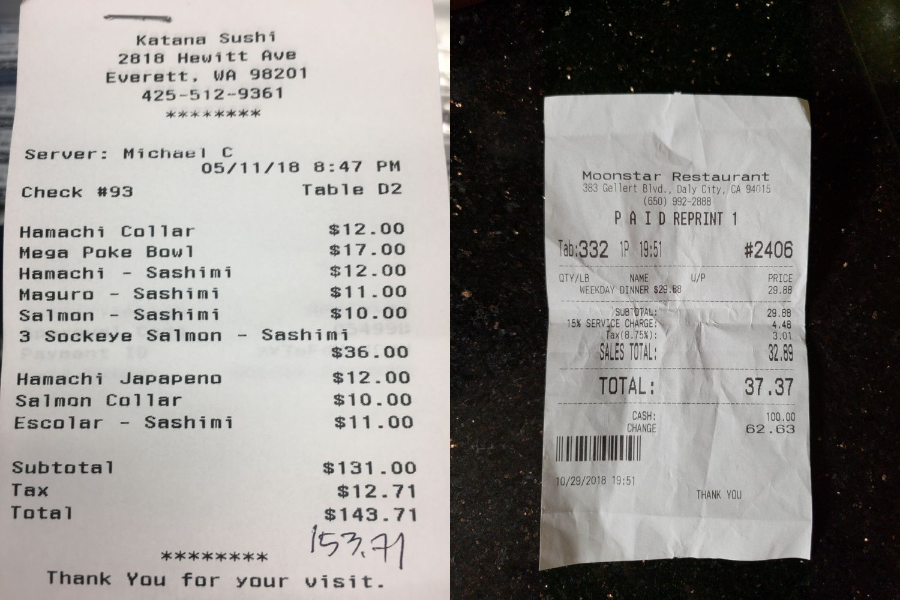

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


img1 = cv2.imread('data/1007-receipt.jpg')
img2 = cv2.imread('data/1022-receipt.jpg')

# Redimensionner les images pour qu'elles aient la même hauteur
height = 600  # Hauteur fixe pour toutes les images
img1 = cv2.resize(img1, (int(img1.shape[1] * height / img1.shape[0]), height))
img2 = cv2.resize(img2, (int(img2.shape[1] * height / img2.shape[0]), height))

# Concaténer les images horizontalement
concatenated_image = np.hstack((img1, img2))

# Afficher l'image concaténée
cv2_imshow(concatenated_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


First we pick an image and apply some processing to try to make it easier for our model to identify the text

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [255, 255,   0, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255,   0, ...,   0,   0,   0]], dtype=uint8)
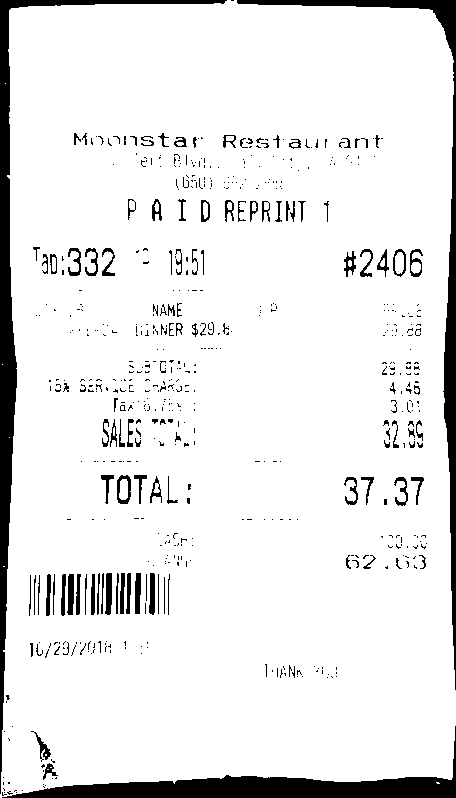

In [ ]:
image = cv2.imread('data/1022-receipt.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray, img_bin = cv2.threshold(image,20,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
thresh = cv2.bitwise_not(img_bin)

contours,hierarchy = cv2.findContours(img_bin, 1, 2)
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if w>100 and h>50:
        break
cropped = img_bin[y:y+h, x:x+w]
cropped

Lets pick and image and try our pipeline.
We first need to use easyOCR to extract the texts and bounding boxes

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

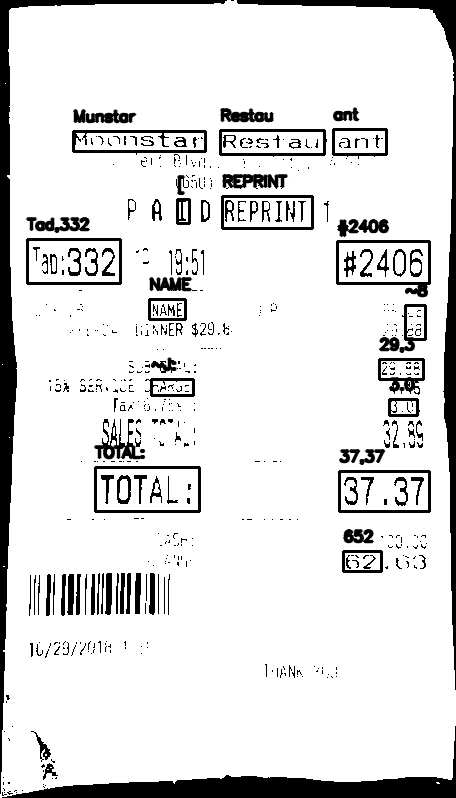

In [ ]:
import easyocr

reader = easyocr.Reader(['en'])

#Apply OCR
results = reader.readtext(cropped)

#Draw bboxes
for (bbox, text, prob) in results:
    if prob > 0.5:
        (top_left, top_right, bottom_right, bottom_left) = bbox
        top_left = tuple(map(int, top_left))
        bottom_right = tuple(map(int, bottom_right))
        cv2.rectangle(cropped, top_left, bottom_right, (0, 0, 255), 2)
        cv2.putText(cropped, text, (top_left[0], top_left[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2, cv2.LINE_AA)

cv2_imshow(cropped)
cv2.waitKey(0)
cv2.destroyAllWindows()

Convert to the right format for our processor

In [ ]:
from PIL import Image
height, width = cropped.shape

pil_image=Image.fromarray(cropped)
pil_image = pil_image.convert("RGB").resize((1000, 1000))

Apply pre processing (Need to try and use one function for our pre processing for both datasets)

In [ ]:
texts = []
bboxes = []
label = []
for (bbox, text, prob) in results:
  (top_left, top_right, bottom_right, bottom_left) = bbox
  texts.append(text)
  scaled = scale_bbox([top_left[0], top_left[1], bottom_right[0], bottom_right[1]], (width, height))
  bbox = [min(max(0, coord), 1000) for coord in scaled]
  bboxes.append(bbox)
  label.append(0)

In [ ]:
from transformers import AutoModelForTokenClassification, AutoProcessor

#Get our finetuned model
model = AutoModelForTokenClassification.from_pretrained("Nautie/layoutlmv3-finetuned-cord_100")
processor = AutoProcessor.from_pretrained("Nautie/layoutlmv3-finetuned-cord_100")

In [ ]:
#Encode
encoding = processor(pil_image , texts, boxes=bboxes, word_labels=label, return_tensors="pt")

In [ ]:
#This time we keep the extra dimension
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 83])
attention_mask torch.Size([1, 83])
bbox torch.Size([1, 83, 4])
labels torch.Size([1, 83])
pixel_values torch.Size([1, 3, 224, 224])


##Forward pass

In [ ]:
attention_mask = encoding['attention_mask'].squeeze().tolist()

In [ ]:
outputs = model(input_ids=encoding['input_ids'], bbox=encoding['bbox'], pixel_values=encoding['pixel_values'], attention_mask=encoding['attention_mask'])

In [ ]:
#Convert back our ids to tokens
tokens = processor.tokenizer.convert_ids_to_tokens(encoding['input_ids'].squeeze().tolist())
clean_tokens = [token.replace('Ġ', '').replace('##', '') for token in tokens]

In [ ]:
#Get tokens with attention maks active and prediciton = 0 which is our class id for total price
filtered_predictions = [tok for pred, tok, mask in zip(predictions, clean_tokens, attention_mask) if pred == 0 and mask == 1]

In [ ]:
''.join(filtered_predictions)

'TOTAL:37,37'

## Conclusions

The LayoutLMv3 model was proposed in LayoutLMv3: Pre-training for Document AI with Unified Text and Image Masking.

The goal of this model is to bring in one solution both NLP and Visual processing. This allows the model to intake more context that using only one or the other. It is especially true for our case. Position of a number on a receipt isn't enough to know what it represent, the same goes for the semantic of the text.

Therefore LayoutLMV3 is well adapted for our application. It performed really well during finetuning and can then be incorporated into a pipeline to classify texts in an image of a receipts as representing the total to pay or not.

There is still room for improvement during the OCR part of our pipeline. We can put more time into finding the right pre-processing for the image and we can imagine a better OCR model capable of recognizing handwriting aswell. There is also a little room for improvement by tweaking our model hyperparameters during training.